# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

For this assignment, you will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle.  

To accomplish this, you must modify the code discussed in lecture for learning to play Tic-Tac-Toe.  Modify the code  so that it learns to solve the three-disk, three-peg
Towers of Hanoi Puzzle.  In some ways, this will be simpler than the
Tic-Tac-Toe code.  

Steps required to do this include the following:

  - Represent the state, and use it as a tuple as a key to the Q dictionary.
  - Make sure only valid moves are tried from each state.
  - Assign reinforcement of $-1$ to each move unless it is a move to the goal state, for which the reinforcement is $0$.  This represents the goal of finding the shortest path to the goal.

Make a plot of the number of steps required to reach the goal for each
trial.  Each trial starts from the same initial state.  Decay epsilon
as in the Tic-Tac-Toe code.

## Requirements

First, how should we represent the state of this puzzle?  We need to keep track of which disks are on which pegs. Name the disks 1, 2, and 3, with 1 being the smallest disk and 3 being the largest. The set of disks on a peg can be represented as a list of integers.  Then the state can be a list of three lists.

For example, the starting state with all disks being on the left peg would be `[[1, 2, 3], [], []]`.  After moving disk 1 to peg 2, we have `[[2, 3], [1], []]`.

To represent that move we just made, we can use a list of two peg numbers, like `[1, 2]`, representing a move of the top disk on peg 1 to peg 2.

Now on to some functions. Define at least the following functions. Examples showing required output appear below.

   - `printState(state)`: prints the state in the form shown below
   - `validMoves(state)`: returns list of moves that are valid from `state`
   - `makeMove(state, move)`: returns new (copy of) state after move has been applied.
   - `trainQ(nRepetitions, learningRate, epsilonDecayFactor)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of steps to reach goal for each repetition.
   - `testQ(Q, maxSteps)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

A function that you might choose to implement is

   - `stateMoveTuple(state, move)`: returns tuple of state and move.  
    
This is useful for converting state and move to a key to be used for the Q dictionary.

# Examples (more coming soon)

To make it easier to visualize the state of the game, the function *printState* is used.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy

In [8]:

#for i in range (100):
 #   v.append(i)
#outcomes = np.random.choice(v,replace=True,size=(1000))


#outcomes[:100]
#Qt= Qt +[1+Q(t+1) - Qt]


In [9]:
def plotOutcomes(outcomes,epsilons,maxGames,nGames):
    if nGames==0:
        return
    nBins = 100
    nPer = int(maxGames/nBins)
    outcomeRows = outcomes.reshape((-1,nPer))
    outcomeRows = outcomeRows[:int(nGames/float(nPer))+1,:]
    avgs = np.mean(outcomeRows,axis=1)
    plt.subplot(3,1,1)
    xs = np.linspace(nPer,nGames,len(avgs))
    plt.plot(xs, avgs)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes\n Number of steps')
    #plt.title('Bins of {:d} Games'.format(nPer))
    '''
    plt.subplot(3,1,2)
    plt.plot(xs,np.sum(outcomeRows==0,axis=1),'g-',label='Wins')
    #plt.plot(xs,np.sum(outcomeRows==-1,axis=1),'r-',label='Losses')
    plt.plot(xs,np.sum(outcomeRows==-1,axis=1),'b-',label='Progress')
    plt.legend(loc="center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(nPer))'''
    plt.subplot(3,1,3)
    plt.plot(epsilons[:nGames])
    plt.ylabel('$\epsilon$')

In [10]:
plt.figure(figsize=(8,8))
#plotOutcomes(outcomes,np.zeros(1000),1000,1000)


In [11]:
def printState(state):
    import copy
    
    stateCopy = copy.deepcopy(state)
    for peg in stateCopy:
        numberDisks=len(peg)
        for pos in range(3-len(peg)):
            peg.insert(pos,' ')
            
    print stateCopy[0][0],stateCopy[1][0],stateCopy[2][0]
    print stateCopy[0][1],stateCopy[1][1],stateCopy[2][1]
    print stateCopy[0][2],stateCopy[1][2],stateCopy[2][2]
    print '------'

In [12]:
state = [[1, 2,3], [], []]
printState(state)


1    
2    
3    
------


The function *validMoves* returns list of moves that are valid from a certain state.
The list returned consists of pairs containing the number of the disk and the peg to which it can be moved.

The following is the list of rules:
- Only one disk can be moved at a time.
- Each move consists of taking the upper disk from one of the stacks and placing it on top of another stack.
- No disk may be placed on top of a smaller disk.



In [13]:
#returns list of moves that are valid from state
def validMoves(state):
    validMoves=[]
    #for each peg 
    for p in range(3):
        if len(state[p]) >0:
            #print state[p]
            for q in range(3):
                if p==q:
                    continue
                else:
                    if len(state[q])>0:
                        if state[p][0] < state[q][0]:
                            validMoves.append([p+1,q+1])
                            #print 'move', state[p][0], 'to', q+1
                    else:
                        #print 'move', state[p][0], 'to', q+1
                        validMoves.append([p+1,q+1])
 
        
    return validMoves
    


In this case, the valid moves that can be perfomed are:
- move the dist 2 to the peg 3
- move the dist 1 to the peg 1
- move the dist 1 to the peg 3


In [14]:
state = [[1], [2], [3]]

validMoves(state)

[[1, 2], [1, 3], [2, 3]]

 The function `makeMove(state, move)` returns new (copy of) state after move has been applied.


In [15]:
def makeMove(state, move):
    import copy
    newState=copy.deepcopy(state)
    disk=move[0]
    peg=move[1]
    del newState[disk-1][0]
    newState[peg-1].insert(0,state[disk-1][0])    
    return newState

In the following example, the disk 1 is moved to peg 3

In [16]:
state = [[1,2,3], [], []]
print validMoves(state)

move=validMoves(state)[1]
print move
newState=makeMove(state, move)
printState(newState)



[[1, 2], [1, 3]]
[1, 3]
     
2    
3   1
------


The funtion stateMoveTuple(state, move) returns tuple of state and move.

In [17]:
def stateMoveTuple(state, move):
    import copy
    newState=copy.deepcopy(state)
    newTuple=[]
    
    for l in range(len(state)):
        newTuple.append(tuple(newState[l]))
    return tuple((tuple(newTuple),tuple(move)))

In [18]:
state = [[1,2,3], [], []]
move =[1, 2]
stateMoveTuple(state, move)


(((1, 2, 3), (), ()), (1, 2))

If nobody won yet, let's calculate the temporal difference error and use it to adjust the Q value of the previous state,move. We do this only if we are not at the first move of a game.

In [19]:
def winner(state):
    disks_in_right_pos_1=0
    disks_in_right_pos_2=0
    for i in range(3):
        if len(state[1]) ==3 and state[1][i]==i+1:
            disks_in_right_pos_1+=1
        if len(state[2]) ==3 and state[2][i]==i+1:
            disks_in_right_pos_2+=1
    return True if disks_in_right_pos_1 ==3 or disks_in_right_pos_2 ==3 else  False
            
state = [ [], [1,2,3],[]]

winner(state)
     

True

In [20]:
def epsilonGreedy(epsilon, Q, state):
    bestMove=[]
    validMovesList = validMoves(state)
    #print validMovesList
    
    if np.random.uniform() < epsilon:
        #print 'Random Move'
        return validMovesList[np.random.choice(len(validMovesList))]
    else:
        #print 'Greedy Move'
        
        Qs = np.array([Q.get(tuple(stateMoveTuple(state, m)), 0) for m in validMovesList]) 
        #print Qs
        bestMove = validMovesList[np.argmax(Qs)]

        return bestMove





In [21]:
from IPython.display import display, clear_output


In [26]:
# train the Q function for number of repetitions, decaying epsilon at start of each repetition.
#Returns Q and list or array of steps to reach goal for each repetition.

def trainQ(nRepetitions, learningRate, epsilonDecayFactor,x,y):
    import copy
    steps=[]
    maxGames = nRepetitions
    rho = learningRate
    epsilonDecayRate=epsilonDecayFactor
    epsilon = 1.0
    outcomes = np.zeros(maxGames)  # empty board
 

    epsilons = np.zeros(maxGames)
    graphics = True
    showMoves= not graphics

    
    
    Q = {}
    if graphics:
        fig = plt.figure(figsize=(10,10))
    for nGames in range(maxGames):
        epsilon *= epsilonDecayRate
        epsilons[nGames] = epsilon
        step = 0
        state= [[1,2,3], [], []]
        done = False
        
        while not done:
            step += 1
            move = epsilonGreedy(epsilon, Q, state)
 
            stateNew=makeMove(state, move)
            

            #state being explored not in dictionary
            if tuple(stateMoveTuple(state, move)) not in Q:
                Q[tuple(stateMoveTuple(state, move))] = -1  # initial Q value for new state,move
                



            if winner(stateNew):
                Q[tuple(stateMoveTuple(state, move))] = 0  
                done = True
            
            

                
            if step > 1:
                Q[tuple(stateMoveTuple(stateOld, moveOld))] += rho * (-1+Q[tuple(stateMoveTuple(state, move))] - Q[tuple(stateMoveTuple(stateOld, moveOld))])

            stateOld=copy.deepcopy(state)   
            moveOld = copy.deepcopy(move) # remember state and move to Q(state,move) can be updated after next steps
            state = copy.deepcopy(stateNew)

        if graphics and (nGames % (maxGames/10) == 0 or nGames == maxGames-1):
            fig.clf() 
            plotOutcomes(outcomes,epsilons,maxGames,nGames-1)
            clear_output(wait=True)
            display(fig);
                
        steps.append(step)
        outcomes[nGames] = step


    

    if graphics:
        clear_output(wait=True)
   # print('Outcomes: {:d} shortest path to win steps to win'.format(outcomes.min()))    
    return Q,steps   
    
    

[98,
 121,
 22,
 74,
 34,
 48,
 12,
 91,
 69,
 43,
 34,
 147,
 58,
 36,
 9,
 88,
 54,
 111,
 26,
 31,
 39,
 43,
 36,
 33,
 43,
 35,
 151,
 15,
 50,
 49,
 65,
 31,
 40,
 144,
 43,
 25,
 235,
 94,
 62,
 114,
 122,
 16,
 29,
 35,
 48,
 80,
 111,
 113,
 36,
 51,
 31,
 46,
 46,
 106,
 44,
 37,
 42,
 30,
 53,
 43,
 103,
 52,
 21,
 38,
 62,
 46,
 11,
 42,
 19,
 75,
 21,
 53,
 39,
 25,
 29,
 31,
 14,
 28,
 65,
 44,
 16,
 36,
 23,
 29,
 42,
 37,
 38,
 40,
 42,
 46,
 34,
 106,
 32,
 44,
 46,
 14,
 47,
 65,
 21,
 84,
 57,
 60,
 70,
 33,
 39,
 92,
 60,
 54,
 71,
 36,
 32,
 19,
 56,
 68,
 47,
 51,
 39,
 71,
 82,
 45,
 77,
 16,
 23,
 20,
 55,
 12,
 48,
 24,
 54,
 55,
 65,
 71,
 44,
 28,
 38,
 11,
 61,
 10,
 36,
 36,
 35,
 39,
 73,
 127,
 27,
 31,
 11,
 9,
 18,
 18,
 17,
 115,
 45,
 25,
 59,
 43,
 17,
 62,
 19,
 41,
 44,
 39,
 50,
 43,
 34,
 35,
 31,
 11,
 24,
 41,
 28,
 27,
 13,
 8,
 16,
 21,
 9,
 13,
 41,
 22,
 25,
 26,
 39,
 41,
 20,
 22,
 29,
 18,
 25,
 21,
 18,
 23,
 31,
 33,
 29,
 49,
 24,
 39,

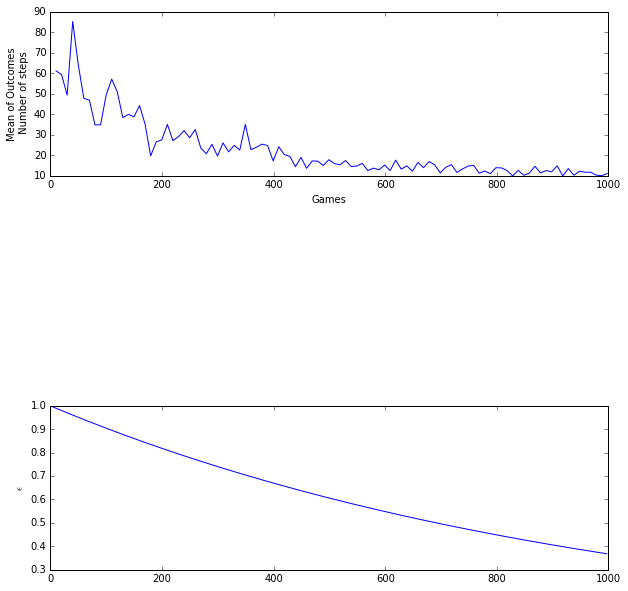

In [33]:
Q, stepsToGoal = trainQ(1000, 0.2, 0.999, validMoves, makeMove)


In [28]:
#without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

def testQ(Q, maxSteps, validMovesF, makeMoveF):
    import copy
    state=[[1,2,3],[],[]]
    win=False
    path=[]
    for step in range(maxSteps):
        while not win:            
            path.append(state)
            move=[]
            validMovesList = validMoves(state)

            Qs = np.array([Q.get(tuple(stateMoveTuple(state, m)), 0)  for m in validMovesList]) 
            move = validMovesList[np.argmax(Qs)]
            stateNew=makeMove(state, move)

            if winner(stateNew):  
                path.append(stateNew)
                win = True

            state = copy.deepcopy(stateNew)
    return path     
        
        
        
        
    

In [34]:
path = testQ(Q, 20,1,2)

In [35]:
path


[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [36]:
for s in path:
    #print s
    printState(s)
    print

1    
2    
3    
------

     
2    
3   1
------

     
     
3 2 1
------

     
  1  
3 2  
------

     
  1  
  2 3
------

     
     
1 2 3
------

     
    2
1   3
------

    1
    2
    3
------




---  0/10 points. Q dictionary should have close to 76 entries. Yours has 67

--- 10/10 points. The mean of the number of steps is 7.23 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, less than 10.

ArtificcialIntelligence Execution Grade is 70/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

ArtificcialIntelligence FINAL GRADE is __/100


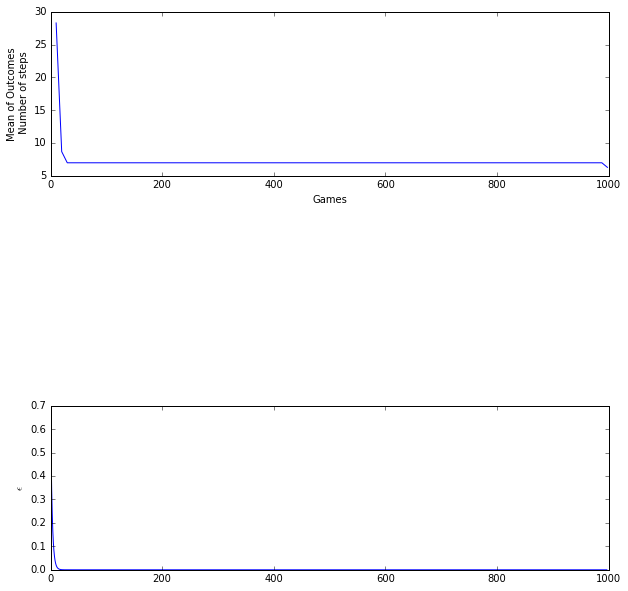

In [32]:
%run -i A5grader.py

In [ ]:
def printState_4disk(state):
    import copy
    
    stateCopy = copy.deepcopy(state)
    for peg in stateCopy:
        numberDisks=len(peg)
        for pos in range(4-len(peg)):
            peg.insert(pos,' ')
            
    print stateCopy[0][0],stateCopy[1][0],stateCopy[2][0]
    print stateCopy[0][1],stateCopy[1][1],stateCopy[2][1]
    print stateCopy[0][2],stateCopy[1][2],stateCopy[2][2]
    print '------'